In [1]:
import time
import math
import random
import os

import numpy as np

import pickle as pkl
import gzip

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import seaborn as sns; sns.set()
sns.set_style("darkgrid")
sns.set_context("paper")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#Windows hack
if "\\" in os.getcwd():
    data_dir = '\\'.join(os.getcwd().split("\\")[:-1]) + '\\data\\'
    emb_dir = '\\'.join(os.getcwd().split("\\")[:-1]) + '\\embeddings\\'
else:
    data_dir = '/'.join(os.getcwd().split("/")[:-1]) + '/data/'
    emb_dir = '/'.join(os.getcwd().split("/")[:-1]) + '/embeddings/'

SPECIAL_SYMBOLS_ID = \
    PAD_ID, UNK_ID, SOS_ID, EOS_ID = \
    0, 1, 2, 3
NUM_SPECIAL = len(SPECIAL_SYMBOLS_ID)

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pkl.load(f)
        return loaded_object

In [3]:
class Lang:
    def __init__(self, name, id2word, word2id, emb, learn_ids):
        self.name = name
        self.id2word = id2word
        self.word2id = word2id
        self.emb = emb

        self.n_words = len(id2word)
        self.learn_ids = learn_ids
        
    def addWords(self, train, dev, test):
        self.train = train
        self.dev = dev
        self.test = test
        
        self.max_length = max([len(s) for s in train])
        
    def addNums(self, train, dev, test):
        self.train_num = [torch.tensor(i, dtype=torch.long, device=device).view(-1,1) for i in train]
        self.dev_num = [torch.tensor(i, dtype=torch.long, device=device).view(-1,1) for i in dev]
        self.test_num = [torch.tensor(i, dtype=torch.long, device=device).view(-1,1) for i in test]


In [4]:
#Vietnamese Language
vi = Lang('vi', 
          load_zipped_pickle(emb_dir + "id2word_vi_dic.p"), 
          load_zipped_pickle(emb_dir + "word2id_vi_dic.p"), 
          load_zipped_pickle(emb_dir + "vi_embeddings_matrix_100K.p"),
          SPECIAL_SYMBOLS_ID)

vi.addWords(load_zipped_pickle(data_dir + "vi-en-tokens/train_vi_tok.p"),
           load_zipped_pickle(data_dir + "vi-en-tokens/dev_vi_tok.p"),
           load_zipped_pickle(data_dir + "vi-en-tokens/test_vi_tok.p"))

vi.addNums(load_zipped_pickle(data_dir + "vi-en-tokens/train_vi_tok_num.p"),
           load_zipped_pickle(data_dir + "vi-en-tokens/dev_vi_tok_num.p"),
           load_zipped_pickle(data_dir + "vi-en-tokens/test_vi_tok_num.p"))


#English Language
en = Lang('en', 
          load_zipped_pickle(emb_dir + "id2word_en_dic.p"), 
          load_zipped_pickle(emb_dir + "word2id_en_dic.p"), 
          load_zipped_pickle(emb_dir + "en_embeddings_matrix_100K.p"),
          SPECIAL_SYMBOLS_ID)

en.addWords(load_zipped_pickle(data_dir + "vi-en-tokens/train_en_tok.p"),
           load_zipped_pickle(data_dir + "vi-en-tokens/dev_en_tok.p"),
           load_zipped_pickle(data_dir + "vi-en-tokens/test_en_tok.p"))

en.addNums(load_zipped_pickle(data_dir + "vi-en-tokens/train_en_tok_num.p"),
           load_zipped_pickle(data_dir + "vi-en-tokens/dev_en_tok_num.p"),
           load_zipped_pickle(data_dir + "vi-en-tokens/test_en_tok_num.p"))


In [5]:
vi_en_train_pairs = [(vi.train[i], en.train[i]) for i in range(len(vi.train))]
vi_en_train_pairs_num = [(vi.train_num[i], en.train_num[i]) for i in range(len(vi.train_num))]

vi_en_dev_pairs = [(vi.dev[i], en.dev[i]) for i in range(len(vi.dev))]
vi_en_dev_pairs_num = [(vi.dev_num[i], en.dev_num[i]) for i in range(len(vi.dev_num))]

vi_en_test_pairs = [(vi.test[i], en.test[i]) for i in range(len(vi.test))]
vi_en_test_pairs_num = [(vi.test_num[i], en.test_num[i]) for i in range(len(vi.test_num))]


In [6]:
class HybridEmbeddings(nn.Module):
    def __init__(self, fixed_embeddings, learned_embeddings):
        super(HybridEmbeddings, self).__init__()
        self.fixed_embeddings = fixed_embeddings
        self.learned_embeddings = learned_embeddings

    @property
    def embedding_dim(self):
        return self.fixed_embeddings.embedding_dim

    def forward(self, ids_tensor):
        
        fixed_ids = (ids_tensor - NUM_SPECIAL) * ((ids_tensor >= NUM_SPECIAL)).long()
        learned_ids = (ids_tensor) * ((ids_tensor <= NUM_SPECIAL)).long()
    
        embeddings = (
            self.fixed_embeddings(fixed_ids)
            + self.learned_embeddings(learned_ids)
        )
        return embeddings
    

def initHybridEmbeddings(raw_emb, learn_ids):

    raw_emb_fixed = raw_emb[[i for i in range(0, raw_emb.shape[0]) if i not in learn_ids],:]
    raw_emb_learn = raw_emb[[i for i in range(0, raw_emb.shape[0]) if i in learn_ids],:]
    
    fixed_embeddings = nn.Embedding(
            raw_emb_fixed.shape[0],
            raw_emb_fixed.shape[1],
            padding_idx=0,
        )
    fixed_embeddings.weight.data.copy_(
            torch.from_numpy(raw_emb_fixed))
    fixed_embeddings.weight.requires_grad = False
    learned_embeddings = nn.Embedding(
            len(learn_ids),
            raw_emb_fixed.shape[1],
            padding_idx=0,
        )
    learned_embeddings.weight.data.copy_(
            torch.from_numpy(raw_emb_learn))
    
    embeddings = HybridEmbeddings(
            fixed_embeddings=fixed_embeddings,
            learned_embeddings=learned_embeddings,
        )
    
    return embeddings

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, params, raw_emb, learn_ids):
        super(EncoderRNN, self).__init__()
        
        self.hidden_size = params['hidden_size']
        self.num_layers = params['num_layers']
        
        self.embedding = initHybridEmbeddings(raw_emb, learn_ids)
        self.gru = nn.GRU(self.embedding.embedding_dim, params['hidden_size'], self.num_layers, batch_first=True, bidirectional=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        output = output[:,:,self.hidden_size]+ output[:,:,self.hidden_size:]
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(2, 1, self.hidden_size, device=device)


In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, params, raw_emb, learn_ids):
        super(DecoderRNN, self).__init__()
        self.hidden_size = params['hidden_size']
        self.num_layers = params['num_layers']
        self.output_size = params['output_size']

        self.embedding = initHybridEmbeddings(raw_emb, learn_ids)
        self.gru = nn.GRU(self.embedding.embedding_dim, params['hidden_size'], self.num_layers, batch_first=True, bidirectional=True)
        self.out = nn.Linear(2*self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden, "_"
    
    def initHidden(self):
        return torch.zeros(2, 1, self.hidden_size, device=device)


In [9]:
class TrainAndEvaluate():
    def __init__(self, pairs, encoder, decoder, criterion, learning_rate, teacher_forcing_ratio, input_lang_length, output_lang_length):
        
        self.pairs = pairs
        
        self.encoder = encoder
        self.decoder = decoder
        
        self.encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
        self.decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
        
        self.criterion = criterion
        
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.input_lang_length = input_lang_length
        self.output_lang_length = output_lang_length
        
        
    def train(self, input_tensor, target_tensor):
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        
        encoder_outputs = torch.zeros(self.input_lang_length, self.encoder.hidden_size, device=device)        
        encoder_hidden = encoder.initHidden()
        
        loss = 0
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = self.encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
        
        decoder_hidden = encoder_hidden
        decoder_input = torch.tensor([[SOS_ID]], device=device)

        if random.random() < self.teacher_forcing_ratio:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
                loss += self.criterion(decoder_output, target_tensor[di])
                decoder_input = target_tensor[di]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                loss += self.criterion(decoder_output, target_tensor[di])
                if decoder_input.item() == EOS_ID:
                    break

        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.item() / target_length
    
    def trainIters(self, n_iters, print_every=1000, plot_every=100):
        start = time.time()
        plot_losses = []
        print_loss_total = 0  # Reset every print_every
        plot_loss_total = 0  # Reset every plot_every

        training_pairs = [random.choice(self.pairs) for i in range(n_iters)]

        for iter in range(1, n_iters + 1):
            training_pair = training_pairs[iter - 1]
            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = self.train(input_tensor, target_tensor)
            print_loss_total += loss
            plot_loss_total += loss

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
        
        self.n_iters = n_iters
        self.losses = plot_losses
        
    def showPlot(self):
        plt.figure()
        fig = plt.figure(figsize=(10,6))
        fig_plt = sns.lineplot(x=np.arange(0, vi_en_trainEvaluater.n_iters, int(vi_en_trainEvaluater.n_iters/len(vi_en_trainEvaluater.losses))), y=vi_en_trainEvaluater.losses)
        fig_plt.set_title("Loss Over Time")
        fig_plt.set_ylabel("Loss")
        fig_plt.set_xlabel("Iterations")
        return fig_plt.get_figure()
        
    def evaluate(self, sentence, id2word):
        with torch.no_grad():
            input_tensor = sentence
            input_length = input_tensor.size()[0]

            encoder_outputs = torch.zeros(self.input_lang_length, self.encoder.hidden_size, device=device)
            encoder_hidden = encoder.initHidden()
            
            for ei in range(input_length):
                encoder_output, encoder_hidden = self.encoder(input_tensor[ei], encoder_hidden)
                encoder_outputs[ei] += encoder_output[0, 0]

            decoder_input = torch.tensor([[SOS_ID]], device=device)  # SOS
            decoder_hidden = encoder_hidden
            decoded_words = []
            decoder_attentions = torch.zeros(self.output_lang_length, self.output_lang_length)

            for di in range(self.output_lang_length):
                decoder_output, decoder_hidden, decoder_attention = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
                if type(decoder_attention) != str:
                    decoder_attentions[di] = decoder_attention.data
                topv, topi = decoder_output.data.topk(1)
                if topi.item() == EOS_ID:
                    decoded_words.append('<eos>')
                    break
                else:
                    decoded_words.append(id2word[topi.item()])

                decoder_input = topi.squeeze().detach()

            return decoded_words#, decoder_attentions[:di + 1]

In [10]:
encoder_params = {'hidden_size':256, 'num_layers':1}
decoder_params = {'hidden_size':encoder_params['hidden_size'], 'num_layers':1, 'output_size':en.n_words}

encoder = EncoderRNN(encoder_params, vi.emb, vi.learn_ids).to(device)
decoder = DecoderRNN(decoder_params, en.emb, en.learn_ids).to(device)

vi_en_trainEvaluater = TrainAndEvaluate(vi_en_train_pairs_num, encoder, decoder, nn.NLLLoss(),  0.01, 0.5, vi.max_length, en.max_length)

In [11]:
vi_en_trainEvaluater.trainIters(10000, 1000, 100)

4m 33s (- 41m 4s) (1000 10%) 5.8248
9m 2s (- 36m 10s) (2000 20%) 5.0860
13m 34s (- 31m 40s) (3000 30%) 5.0445
18m 5s (- 27m 8s) (4000 40%) 5.0959
22m 30s (- 22m 30s) (5000 50%) 5.0541
27m 13s (- 18m 9s) (6000 60%) 5.2627
31m 58s (- 13m 42s) (7000 70%) 4.9775
36m 35s (- 9m 8s) (8000 80%) 5.0420
41m 31s (- 4m 36s) (9000 90%) 4.9886
46m 12s (- 0m 0s) (10000 100%) 4.9986


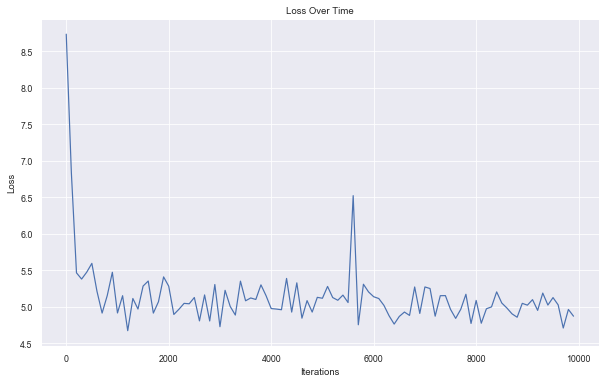

In [12]:
plt.close('all')
vi_en_trainEvaluater.showPlot()

In [13]:
vi_en_trainEvaluater.evaluate(vi_en_dev_pairs_num[0][0], en.id2word)

['<sos>',
 'and',
 'i',
 ',',
 'we',
 'have',
 'to',
 'the',
 'the',
 'of',
 'the',
 ',',
 'and',
 'the',
 'the',
 'of',
 'the',
 'of',
 'the',
 'of',
 'the',
 '.',
 '<eos>']